# Kaggle Titanic
##### Author: Alan, Jerry

### Import and Load

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold

In [301]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Data and Plots

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Variable Survival Analysis

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

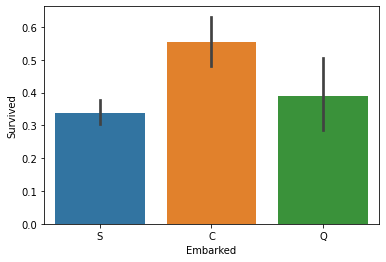

In [42]:
sns.barplot(data=train,x='Embarked',y='Survived')

Passengers with embarked C have higher suvival rate.

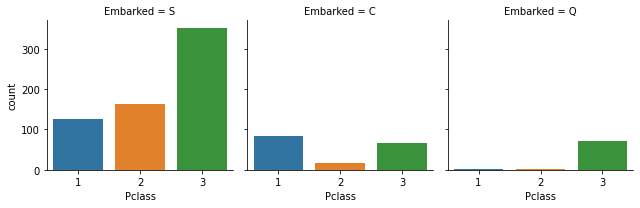

In [60]:
sns.factorplot('Pclass', col='Embarked', data=train, kind='count', size=3)

Passengers with embarked C have higher rate of 1st class.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

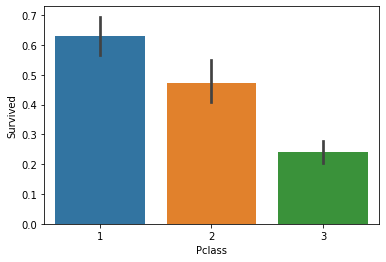

In [47]:
sns.barplot(data=train,x='Pclass',y='Survived')

Passengers with 1st class have higher survival rate.

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

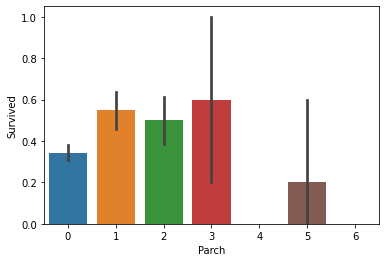

In [48]:
sns.barplot(data=train,x='Parch',y='Survived')

Passengers with 1-3 parches have higher survival rate.

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

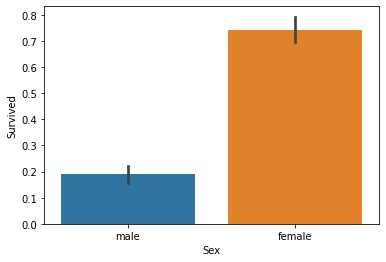

In [61]:
sns.barplot(data=train,x='Sex',y='Survived')

Female passengers have much higher survival rate then Male.

<AxesSubplot:xlabel='Age', ylabel='Density'>

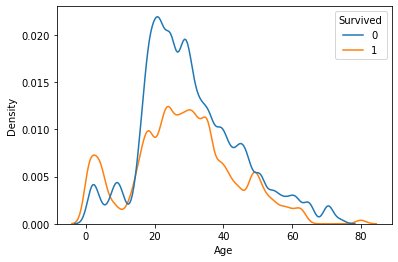

In [68]:
sns.kdeplot(data=train, x="Age", hue="Survived", bw = 0.1)

Passengers with age at 0-10 and 50-60 have higher survival rate.

<AxesSubplot:xlabel='Fare', ylabel='Density'>

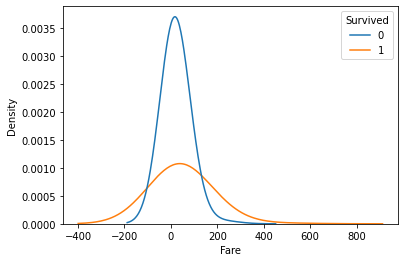

In [91]:
sns.kdeplot(data=train, x="Fare", hue="Survived", bw = 2)

Passengers with fare price over 100 have high survival rate.

### Missingness and Process

In [329]:
df = train.append(test, ignore_index = True)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

· Split appellative out of name

· Fill missingness for Age, Cabin, Embark

In [330]:
df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [331]:
df['Cabin'] = df.Cabin.fillna('NAN')

df['Embarked'] = df.Embarked.fillna('S') # fill with most-common S

df['Fare'] = df['Fare'].fillna(df[(df['Pclass']==3)&(df['Embarked']=='S')&(df['Cabin']=='NAN')]['Fare'].mean())

In [332]:
df["Name"] = df.Name.apply(lambda x: x.split(", ")[1].split(".")[0] if x is not np.NaN else "NAN")
df.Name.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Jonkheer          1
Dona              1
Capt              1
the Countess      1
Sir               1
Lady              1
Don               1
Mme               1
Name: Name, dtype: int64

Categorize these rare appellatives.

In [334]:
d = {}
d['Mr']='Mr'
d['Miss']='Miss'
d['Mrs']='Mrs'
d['Master']='Master'
d['Dr']='Officer'
d['Rev']='Officer'
d['Mlle']='Miss'
d['Col']='Officer'
d['Major']='Officer'
d['Capt']='Officer'
d['Sir']='Royalty'
d['Mme']='Mrs'
d['Jonkheer']='Master'
d['Dona']='Royalty'
d['Don']='Royalty'
d['Lady']='Royalty'
d['Ms']='Mrs'
d['the Countess']='Royalty'
df['Name'] = df['Name'].map(d)
df['Name'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Name, dtype: int64

<AxesSubplot:xlabel='Name', ylabel='Survived'>

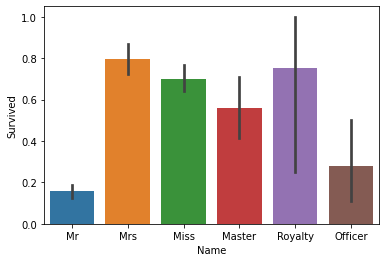

In [335]:
sns.barplot(data=df,x='Name',y='Survived')

Passengers with 'Mr' and 'Officer' have lower survival rate.

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

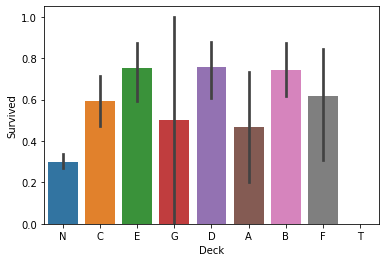

In [336]:
df['Deck'] = df['Cabin'].map(lambda x:x[0])
sns.barplot(data=df, x='Deck', y='Survived')

Passengers at B/D/E deck have higher survival rate.

#### Age and Randrom Forest

In [337]:
df[df['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
5,6,0.0,3,Mr,male,NaN,0,0,330877,8.4583,NAN,Q,N
17,18,1.0,2,Mr,male,NaN,0,0,244373,13.0000,NAN,S,N
19,20,1.0,3,Mrs,female,NaN,0,0,2649,7.2250,NAN,C,N
26,27,0.0,3,Mr,male,NaN,0,0,2631,7.2250,NAN,C,N
28,29,1.0,3,Miss,female,NaN,0,0,330959,7.8792,NAN,Q,N


In [338]:
df['familyNum']=df['Parch']+df['SibSp']+1

In [339]:
Age = df[['Age', 'Parch', 'Pclass', 'SibSp', 'familyNum']]

Age_Pre = pd.get_dummies(Age)
Par_Age = pd.get_dummies(Age['Parch'], prefix='Parch')
Sib_Age = pd.get_dummies(Age['SibSp'], prefix='SibSp')
P_Age=pd.get_dummies(Age['Pclass'], prefix='Pclass')

AgeCorrDf=pd.DataFrame()
AgeCorrDf=Age.corr()
AgeCorrDf['Age'].sort_values()

Pclass      -0.408106
SibSp       -0.243699
familyNum   -0.240229
Parch       -0.150917
Age          1.000000
Name: Age, dtype: float64

In [340]:
AgeKnown = Age[Age['Age'].notnull()]
AgeUnKnown = Age[Age['Age'].isnull()]
AgeKnown_X = AgeKnown.drop(['Age'],axis=1)
AgeKnown_y = AgeKnown['Age']
AgeUnKnown_X = AgeUnKnown.drop(['Age'],axis=1)
rfr = RandomForestRegressor(random_state=None, n_estimators = 500, n_jobs = -1)
rfr.fit(AgeKnown_X, AgeKnown_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [341]:
rfr.score(AgeKnown_X, AgeKnown_y)

0.3500991320136184

In [342]:
AgeUnKnown_y = rfr.predict(AgeUnKnown_X)
df.loc[df['Age'].isnull(), ['Age']] = AgeUnKnown_y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Deck         1309 non-null   object 
 13  familyNum    1309 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 143.3+ KB


#### No missingness

### Model and Prediction

In [343]:
df1 = df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
corrDf=pd.DataFrame()
corrDf=df1.corr()
corrDf['Survived'].sort_values(ascending=True)

Pclass      -0.338481
Age         -0.048824
SibSp       -0.035322
familyNum    0.016639
Parch        0.081629
Fare         0.257307
Survived     1.000000
Name: Survived, dtype: float64

In [344]:
df1=df1.drop(['familyNum','SibSp','Parch'],axis = 1)
df1=pd.get_dummies(df1)
PclassDf = pd.get_dummies(full['Pclass'], prefix = 'Pclass')

df1 = pd.concat([df1,PclassDf], axis = 1)
df1.head()

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T,Pclass_1,Pclass_2,Pclass_3
0,0.0,3,22.0,7.2500,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,1.0,1,38.0,71.2833,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1.0,3,26.0,7.9250,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1.0,1,35.0,53.1000,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0.0,3,35.0,8.0500,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [357]:
experData = df1[df1['Survived'].notnull()]
preData = df1[df1['Survived'].isnull()]

experData_X = experData.drop('Survived', axis = 1)
experData_y = experData['Survived']
preData_X = preData.drop('Survived', axis = 1)
preData_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   Fare        418 non-null    float64
 3   Sex_female  418 non-null    uint8  
 4   Sex_male    418 non-null    uint8  
 5   Embarked_C  418 non-null    uint8  
 6   Embarked_Q  418 non-null    uint8  
 7   Embarked_S  418 non-null    uint8  
 8   Deck_A      418 non-null    uint8  
 9   Deck_B      418 non-null    uint8  
 10  Deck_C      418 non-null    uint8  
 11  Deck_D      418 non-null    uint8  
 12  Deck_E      418 non-null    uint8  
 13  Deck_F      418 non-null    uint8  
 14  Deck_G      418 non-null    uint8  
 15  Deck_N      418 non-null    uint8  
 16  Deck_T      418 non-null    uint8  
 17  Pclass_1    418 non-null    uint8  
 18  Pclass_2    418 non-null    uint8  
 19  Pclass_3    418 non-null  

In [358]:
kfold=StratifiedKFold(n_splits=10)
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())

In [359]:
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

In [360]:
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cvResDf=pd.DataFrame({'algorithm':['SVC','DecisionTree','RandomForest','GradientBoosting','KNN','LR'], 
'cv_mean':cv_means, 'cv_std':cv_std })

cvResDf

,algorithm,cv_mean,cv_std
0,SVC,0.673483,0.047074
1,DecisionTree,0.792434,0.039186
2,RandomForest,0.807054,0.045687
3,GradientBoosting,0.823845,0.045256
4,KNN,0.722834,0.038829
5,LR,0.798040,0.031280


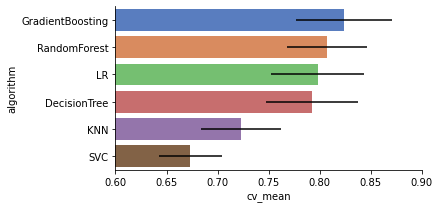

In [361]:
cvResFacet=sns.FacetGrid(cvResDf.sort_values(by = 'cv_mean', ascending = False), sharex = False, sharey = False, aspect = 2)
cvResFacet.map(sns.barplot, 'cv_mean', 'algorithm', **{'xerr':cv_std},
               palette='muted')
cvResFacet.set(xlim = (0.6, 0.9))
cvResFacet.add_legend()

In [362]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
modelgsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, 
                                     scoring = "accuracy", n_jobs= -1, verbose = 1)
modelgsGBC.fit(experData_X, experData_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [363]:
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)

modelgsGBC模型得分为：0.823


In [364]:
#TitanicGBSmodle
GBCpreData_y = modelgsGBC.predict(preData_X)

In [365]:
GBCpreData_y = GBCpreData_y.astype(int)

GBCpreResultDf = pd.DataFrame()
GBCpreResultDf['PassengerId'] = full['PassengerId'][full['Survived'].isnull()]
GBCpreResultDf['Survived'] = GBCpreData_y

GBCpreResultDf.to_csv('draft.csv')